## Script to plot a panel figure with multiple input files

This example loads precipitation and computes the sum throughout the period for plotting. <br>
Other variables may require mean instead of sum.
Precip requires importing two variables, other variables may be directly available from wrfouts
A list of available variables from wrf-python may be found here: https://wrf-python.readthedocs.io/en/latest/user_api/generated/wrf.getvar.html

Import modules

In [8]:
import xarray as xr
import netCDF4 as nc
import numpy as np
import string
from glob import glob
import wrf as wrf

import matplotlib.pyplot as plt
import cartopy.crs as crs
import cartopy.feature as cfeature

#Required for cartopy v0.17 and below
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER


Defining experiments avaiable

In [9]:
sims=['CTL','SST','NOTOPO','SSTNOTOPO']
#Labels for plotting
labels = ['CTL',' + 2\u00B0C SST','NOTOPO','NOTOPO + 2\u00B0C SST']

Loading geo info (shared by all simulations)

In [10]:
#getting geographical info for plotting
geo_filename = './geo_em.d01.nc'
geo_proj = wrf.get_cartopy(wrfin=nc.Dataset(geo_filename))
xbounds = wrf.cartopy_xlim(wrfin=nc.Dataset(geo_filename))
ybounds = wrf.cartopy_ylim(wrfin=nc.Dataset(geo_filename))

geo_file = xr.open_dataset(geo_filename)
lats = geo_file.XLAT_M.squeeze().values
lons = geo_file.XLONG_M.squeeze().values

### Example of plotting precipitation

Creating figure holder

In [11]:
fig = plt.figure(figsize=(10,10))

<Figure size 720x720 with 0 Axes>

Looping through simulations (loading)

In [12]:
PR = {}

for n,sim in enumerate(sims):    
    #Listing input files
    filenames = sorted(glob(f"./{sim}/wrfout_d01_2018-*"))
    
    #Loading all files with netCDF4 
    wrfin = [nc.Dataset(f) for f in filenames]
    #Loading convective and non-convective precipitation
    PR_NC = wrf.getvar(wrfin,'PREC_ACC_NC',timeidx=wrf.ALL_TIMES)
    PR_C = wrf.getvar(wrfin,'PREC_ACC_C',timeidx=wrf.ALL_TIMES)
    
    PR[sim] = PR_NC.sum('Time')+PR_C.sum('Time')
    

Looping through simulations (plotting)

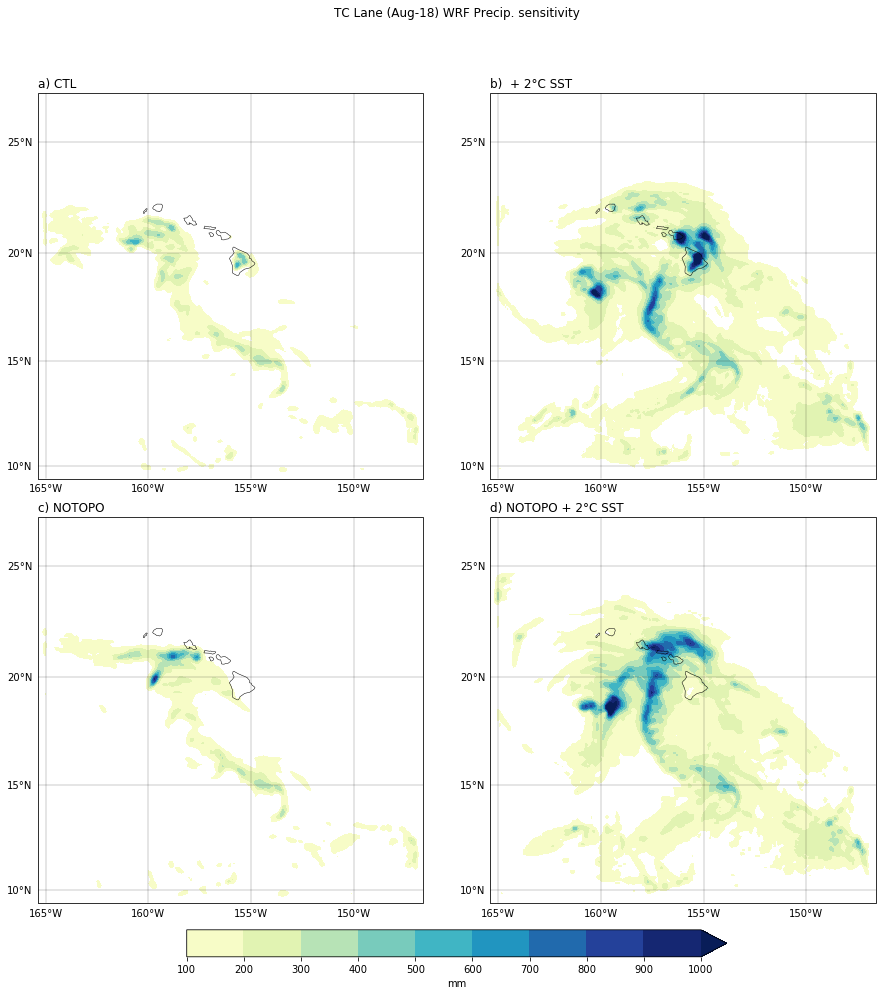

In [13]:
fig = plt.figure(figsize=(15, 15))
for n,sim in enumerate(sims):
    ax = fig.add_subplot(2,2,n+1,projection=geo_proj)
    ax.set_title(f'{string.ascii_lowercase[n]}) {labels[n]}',loc='left')
    ax.coastlines(linewidth=0.5,zorder=102,resolution='50m')
    ct=ax.contourf(lons,lats,PR[sim],levels=np.arange(100,1100,100),cmap='YlGnBu',extend='max',transform=crs.PlateCarree())
    ax.set_xlim(xbounds)
    ax.set_ylim(ybounds)
    gl=ax.gridlines(crs=crs.PlateCarree(), xlocs=range(-180,181,5), ylocs=range(-80,81,5),
                     draw_labels=True, zorder=102,
                     linewidth=0.2, color='k', alpha=1, linestyle='-')

    
    #Cartopy v0.17 and below
#     gl.xlabels_top = False
#     gl.ylabels_left = False
#     gl.xformatter = LONGITUDE_FORMATTER
#     gl.yformatter = LATITUDE_FORMATTER
    #Cartopy v0.18 and later
    gl.top_labels = False
    gl.right_labels = False
    
plt.suptitle("TC Lane (Aug-18) WRF Precip. sensitivity")
cbar_ax = fig.add_axes([0.25, 0.1, 0.5, 0.025])
cb1=plt.colorbar(ct,cax=cbar_ax,ticks=range(100,1100,100),orientation="horizontal",shrink=.62)
cb1.set_label('mm')
fig.subplots_adjust(left=0.1,right=0.9,top=0.9,bottom=0.15,wspace=0.1,hspace=0.1)
# #uncomment if you want to save the figure
# #plt.savefig('outputfig.png')

### Another example plotting differences in precip. with CTL

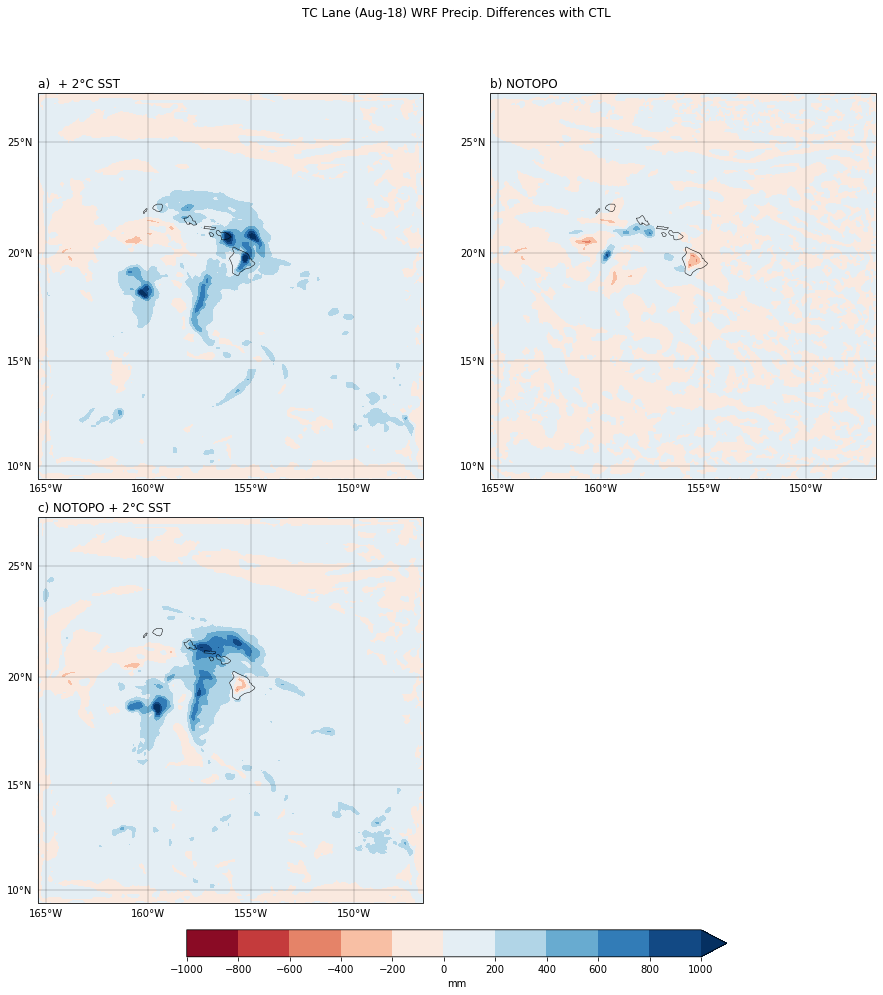

In [15]:
fig = plt.figure(figsize=(15, 15))
for n,sim in enumerate(sims):
    if sim != 'CTL':
        ax = fig.add_subplot(2,2,n,projection=geo_proj)
        ax.set_title(f'{string.ascii_lowercase[n-1]}) {labels[n]}',loc='left')
        ax.coastlines(linewidth=0.5,zorder=102,resolution='50m')
        ct=ax.contourf(lons,lats,PR[sim]-PR['CTL'],levels=np.arange(-1000,1200,200),cmap='RdBu',extend='max',transform=crs.PlateCarree())
        ax.set_xlim(xbounds)
        ax.set_ylim(ybounds)
        gl=ax.gridlines(crs=crs.PlateCarree(), xlocs=range(-180,181,5), ylocs=range(-80,81,5),
                         draw_labels=True, zorder=102,
                         linewidth=0.2, color='k', alpha=1, linestyle='-')


        #Cartopy v0.17 and below
#         gl.xlabels_top = False
#         gl.ylabels_left = False
#         gl.xformatter = LONGITUDE_FORMATTER
#         gl.yformatter = LATITUDE_FORMATTER
        #Cartopy v0.18 and later
        gl.top_labels = False
        gl.right_labels = False
    
plt.suptitle("TC Lane (Aug-18) WRF Precip. Differences with CTL")
cbar_ax = fig.add_axes([0.25, 0.1, 0.5, 0.025])
cb1=plt.colorbar(ct,cax=cbar_ax,ticks=range(-1000,1200,200),orientation="horizontal",shrink=.62)
cb1.set_label('mm')
fig.subplots_adjust(left=0.1,right=0.9,top=0.9,bottom=0.15,wspace=0.1,hspace=0.1)
# #uncomment if you want to save the figure
# #plt.savefig('outputfig.png')